In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from binance.client import Client
from binance.enums import HistoricalKlinesType

api_key = 'y9m94JvyDsSRyHZUQjNN1lVfDnduNMFyQxz83EW650XKwgbIXxB85xGv7CDQfW8Z'
api_secret = 'cHvzTpnE3Qp468ZcAIadtIQSKvV6HdbXsnwbTAhlTCg9Q0uydcxVKUwP7rqLrcpl'

klines_column_names = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 
                       'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']

client = Client(api_key, api_secret)

In [2]:
# setting
atr_length = 10
factor = 3

stoploss = 0.2 # 20%
rnr = 1.5
leverage = 10

## Get data

In [3]:
klines = client.get_historical_klines(symbol="ETHUSDT", 
                                      interval=Client.KLINE_INTERVAL_30MINUTE, 
                                      start_str="1 week ago UTC", 
                                      klines_type=HistoricalKlinesType.FUTURES)

In [4]:
df_klines = pd.DataFrame(klines, columns=klines_column_names).set_index('Open time')
df_klines.index = pd.to_datetime(df_klines.index, unit='ms')
df_klines = df_klines.astype({'Open':'float32', 'High':'float32', 'Low':'float32', 'Close':'float32', 'Volume': 'float32'})

data = df_klines[['Open', 'High', 'Low', 'Close', 'Volume']]

## Heikin Ashi

In [4]:
def heikin_ashi(data):
    ha_data = data.copy()
    ha_data['Close'] = (data.Open + data.Low + data.Close + data.High) / 4

    for i in range(data.shape[0]):
        if i > 0:
            ha_data['Open'].iloc[i] = (ha_data.iloc[i-1].Open + ha_data.iloc[i-1].Close) / 2
    ha_data['High'] = ha_data[['High', 'Close', 'Open']].max(axis=1)
    ha_data['Low'] = ha_data[['Low', 'Close', 'Open']].min(axis=1)
    
#     ha_data = ha_data.drop(ha_data.index[0])
    return ha_data

In [5]:
ha_data = heikin_ashi(data)

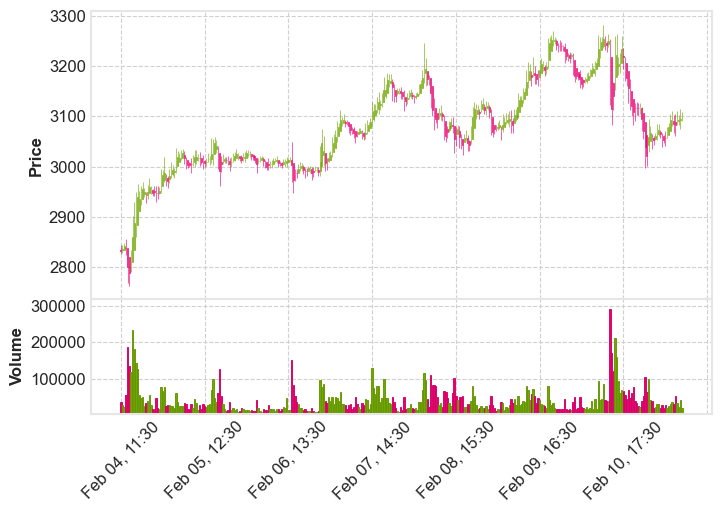

In [6]:
# mpf.available_styles()
mpf.plot(ha_data, figratio=(12, 8), type="candle", volume=True, tight_layout=False, style="binance")

## Supertrend

In [7]:
def true_range(data):
    """
    https://www.investopedia.com/terms/a/atr.asp
    
    data -> pd.DataFrame
    data consist of OCHL column
    """
    
    return pd.concat([data['High'] - data['Low'], 
                      data['High'] - data['Close'].shift(1), 
                      data['Low'] - data['Close'].shift(1)], 
                     axis=1).abs().max(axis=1)

In [8]:
def sma(data, window):
    """
    data -> pd.Series
    """
    return data.rolling(window).mean()

In [9]:
def ema(data, window):
    """
    https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
    
    data -> pd.Series
    """
    return data.ewm(span=window).mean()

In [10]:
def average_true_range(data, window, smoothing='ema'):
    """
    data -> pd.DataFrame
    smoothing -> ema, sma, rma, wma
    data consist of OCHL column
    
    """
    
    if smoothing == 'ema':
        return ema(true_range(data), window)
    elif smoothing == 'sma':
        return sma(true_range(data), window)

In [11]:
def supertrend(data, atr_length=10, factor=3, smoothing='sma'):
    """
    https://www.tradingview.com/support/solutions/43000634738-supertrend/#:~:text=Definition,direction%20and%20to%20position%20stops.
    https://medium.com/codex/step-by-step-implementation-of-the-supertrend-indicator-in-python-656aa678c111
    
    data -> pd.DataFrame
    data consist of OCHL
    
    1. Compute ATR = MovingAverage(TrueRange(data))
    2. Compute HLA = (High + Low) / 2
    3. Compute basic up and down band = HLA +- (factor * ATR)
    4. Compute final up and down band
    5. Computer Supertrend
        Loop through all data
        if Previous Supertrend == Previous Final Up Band
            if Current Close > Current Final Up Band
                Current Supertrend = Current Final Down Band
            else
                Current Supertrend = Current Final Up Band
        else
            if Current Close < Current Final Down Band
                Current Supertrend = Current Final Up Band
            else:
                Current Supertrend = Current Final Down Band
    """
    atr = average_true_range(data, atr_length, smoothing=smoothing)
    
    hla = (data.High + data.Low) / 2
    basic_upband = hla + (factor * atr)
    basic_downband = hla - (factor * atr)
    
    if basic_upband.isna().any() or basic_downband.isna().any():
        basic_upband = basic_upband.fillna(0)
        basic_downband = basic_downband.fillna(0)
    
    final_band = [] # up, down
    for i in range(len(data)):
        if i == 0:
            final_band.append([0, 0])
        else:
            if (basic_upband.iloc[i] < final_band[i-1][0]) | (data.iloc[i-1].Close > final_band[i-1][0]):
                current_final_upband = basic_upband.iloc[i]
            else:
                current_final_upband = final_band[i-1][0]

            if (basic_downband.iloc[i] > final_band[i-1][1]) | (data.iloc[i-1].Close < final_band[i-1][1]):
                current_final_downband = basic_downband.iloc[i]
            else:
                current_final_downband = final_band[i-1][1]

            final_band.append([current_final_upband, current_final_downband])
    
    supertrend = []
    for i in range(len(data)):
        if i==0:
            supertrend.append(0)
        else:
            if supertrend[i-1] == final_band[i-1][0]:
                if data.iloc[i].Close > final_band[i][0]:
                    supertrend.append(final_band[i][1])
                else:
                    supertrend.append(final_band[i][0])

            else:
                if data.iloc[i].Close < final_band[i][1]:
                    supertrend.append(final_band[i][0])
                else:
                    supertrend.append(final_band[i][1])
    
    return supertrend

In [20]:
# add new column for uptrend and downtrend
ha_data['supertrend'] = supertrend(ha_data, smoothing='ema')
ha_data = ha_data.assign(supertrend_down=lambda x: x.apply(lambda y: y.supertrend if y.Close < y.supertrend else np.nan, axis=1))
ha_data = ha_data.assign(supertrend_up=lambda x: x.apply(lambda y: y.supertrend if y.Close > y.supertrend else np.nan, axis=1))

ha_data = ha_data[ha_data.supertrend != 0]

In [21]:
# create signal column
ha_data = ha_data.assign(signal=lambda x: (x.supertrend_down > 0).astype(int))
ha_data.signal = (ha_data.signal - ha_data.signal.shift(-1)).shift(1)
ha_data.signal = ha_data.signal.replace(0, np.nan)

long_signal = ha_data.signal.replace(-1, np.nan) * ha_data.supertrend * 0.99
short_signal = (ha_data.signal.replace(1, np.nan) * ha_data.supertrend * 1.01).abs()

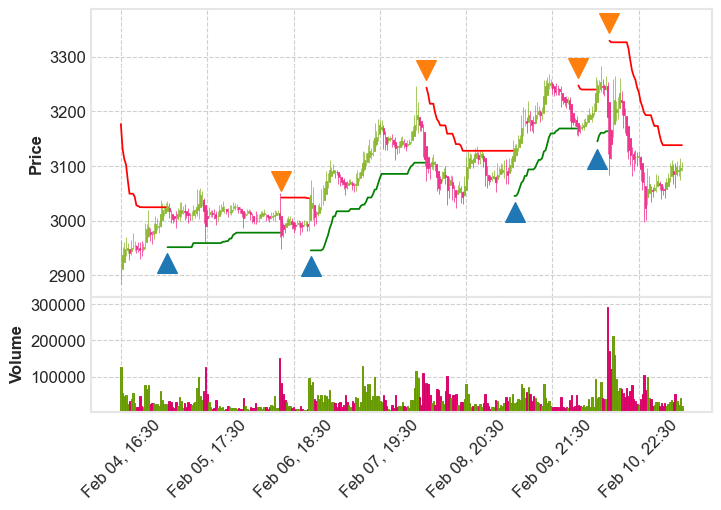

In [22]:
# https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb

apds = [
    mpf.make_addplot(ha_data.supertrend_up, color='green'),
    mpf.make_addplot(ha_data.supertrend_down, color='red'),
    mpf.make_addplot(long_signal,type='scatter',markersize=200,marker='^'),
    mpf.make_addplot(short_signal,type='scatter',markersize=200,marker='v')
]

mpf.plot(ha_data, figratio=(12, 8), type="candle", volume=True, tight_layout=False, style="binance", addplot=apds)

## Backtest

In [ ]:
profit = 0 # percentage
in_position = False
trades = []

for idx, (_, values) in enumerate(ha_data.iterrows()):
    if values.signal == 1:
        # long
        long_price = values.Close
        trades.append({
            'Entry Price': long_price,
            'Close Price': None,
            'Position': 'Long',
            'SL' : long_price * (1 - stoploss / leverage),
            'TP' : 
            'Profit (%)': None
        })
        if in_position:
            p = (trades[idx-1]['Entry Price'] - long_price) / trades[idx-1]['Entry Price']
            trades[idx-1]['Profit (%)'] = p * 100
            trades[idx-1]['Close Price'] = long_price
            profit += p
        else:
            in_position = True
    elif values.signal == 0:
        # short
        short_price = values.Close
        trades.append({
            'Entry Price': short_price,
            'Close Price': None,
            'Position': 'Short',
            'Profit (%)': None
        })
        if in_position:
            p = (short_price - trades[idx-1]['Entry Price']) / short_price
            trades[idx-1]['Profit (%)'] = p * 100
            trades[idx-1]['Close Price'] = short_price
            profit += p
        else:
            in_position = True
    else:
        if in_position:
            if trades[-1]['Position'] == 'Long':
                
                if values.Close 

trades = pd.DataFrame(trades)

In [23]:
profit = 0 # percentage
in_position = False
trades = []

for idx, (_, values) in enumerate(ha_data.dropna(subset='signal').iterrows()):
    if values.signal == 1:
        # long
        long_price = values.Close
        trades.append({
            'Entry Price': long_price,
            'Close Price': None,
            'Position': 'Long',
            'Profit (%)': None
        })
        if in_position:
            p = (trades[idx-1]['Entry Price'] - long_price) / trades[idx-1]['Entry Price']
            trades[idx-1]['Profit (%)'] = p * 100
            trades[idx-1]['Close Price'] = long_price
            profit += p
        else:
            in_position = True
    else:
        # short
        short_price = values.Close
        trades.append({
            'Entry Price': short_price,
            'Close Price': None,
            'Position': 'Short',
            'Profit (%)': None
        })
        if in_position:
            p = (short_price - trades[idx-1]['Entry Price']) / short_price
            trades[idx-1]['Profit (%)'] = p * 100
            trades[idx-1]['Close Price'] = short_price
            profit += p
        else:
            in_position = True

trades = pd.DataFrame(trades)

In [24]:
trades

,Entry Price,Close Price,Position,Profit (%)
0,3026.619873,2974.180176,Long,-1.763165
1,2974.180176,3046.949951,Short,-2.446717
2,3046.949951,3096.870117,Long,1.611955
3,3096.870117,3132.662598,Short,-1.155763
4,3132.662598,3164.285156,Long,0.999359
5,3164.285156,3248.939941,Short,-2.675321
6,3248.939941,3114.062500,Long,-4.331237
7,3114.062500,NaN,Short,NaN


In [25]:
print('Total profit (%) = ', trades['Profit (%)'].sum(), '%')

Total profit (%) =  -9.760889275204843 %
